In [141]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import geopandas as gpd
import pandas as pd
from typing import Callable, List, Tuple

from data.flood_event_1d2d_dataset import FloodEvent1D2DDataset
from utils import file_utils, plot_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Dataset Visualization

In [142]:
config_path = 'configs/config_1d2d_model1.yaml'
config = file_utils.read_yaml_file(config_path)

In [143]:
mode = 'train' # 'train' or 'test'

dataset_parameters = config['dataset_parameters']
if mode == 'train':
    dataset_summary_file = dataset_parameters['training']['dataset_summary_file']
    event_stats_file = dataset_parameters['training']['event_stats_file']
else: # mode == 'test'
    dataset_summary_file = dataset_parameters['testing']['dataset_summary_file']
    event_stats_file = dataset_parameters['testing']['event_stats_file']

delta_t = dataset_parameters['timestep_interval']
previous_timesteps = dataset_parameters['previous_timesteps']
dataset = FloodEvent1D2DDataset(
    mode=mode,
    root_dir=dataset_parameters['root_dir'],
    dataset_summary_file=dataset_summary_file,
    nodes_2d_shp_file=dataset_parameters['nodes_2d_shp_file'],
    edges_2d_shp_file=dataset_parameters['edges_2d_shp_file'],
    nodes_1d_shp_file=dataset_parameters['nodes_1d_shp_file'],
    edges_1d_shp_file=dataset_parameters['edges_1d_shp_file'],
    edges_1d2d_shp_file=dataset_parameters['edges_1d2d_shp_file'],
    dem_file=dataset_parameters['dem_file'],
    event_stats_file=event_stats_file,
    features_stats_file=dataset_parameters['features_stats_file'],
    previous_timesteps=dataset_parameters['previous_timesteps'],
    normalize=dataset_parameters['normalize'],
    timestep_interval=delta_t,
    spin_up_time=dataset_parameters['spin_up_time'],
    time_from_peak=dataset_parameters['time_from_peak'],
    inflow_boundary_nodes=dataset_parameters['inflow_boundary_nodes'],
    outflow_boundary_nodes=dataset_parameters['outflow_boundary_nodes'],
    with_global_mass_loss=False,
    with_local_mass_loss=False,
    force_reload=True,
    save=False,
    perimeter_name=dataset_parameters['perimeter_name'],
)

HecRas Files: ['HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p04.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p86.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p44.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p68.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p80.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p70.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p03.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p76.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p36.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p83.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p17.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p87.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p30.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p67.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p91.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p08.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p66.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p51.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p31.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p55.hdf', 'HEC-RAS_Results/BeaverLAKE_Pipe_Mod.p34.hdf'

In [144]:
print(f'Total number of events: {len(dataset.hec_ras_run_ids)}')
print(f'Total number of timesteps: {len(dataset)}')

Total number of events: 39
Total number of timesteps: 9138


In [145]:
if mode == 'train':
    start_ts = 0
    end_ts = None
else:  # mode == 'test'
    rollout_start = config['testing_parameters']['rollout_start']
    rollout_timesteps = config['testing_parameters']['rollout_timesteps']
    start_ts = rollout_start
    end_ts = (start_ts + rollout_timesteps) if rollout_timesteps is not None else None

delta_t_in_hours = delta_t / 3600
num_events = len(dataset.hec_ras_run_ids)
tick_interval_in_hours = 12

In [146]:
from typing import Optional, Union


def plot_timeseries_per_event(
    dynamic_paths: List[str],
    data_key: str,
    feature_name: str,
    feature_idx: int,
    ylabel: str,
    title: str,
    aggregation_func: Callable = None,
    mask: np.ndarray = None,
):
    longest_hours_elapsed = []
    for run_id, path in zip(dataset.hec_ras_run_ids, dynamic_paths):
        data = np.load(path)[data_key][previous_timesteps:]
        feature_data = data[start_ts:end_ts, :, feature_idx]

        if mask is not None:
            # print(f'Applying mask: {mask}')
            feature_data = feature_data[:, mask]

        feature_data = dataset.normalizer.denormalize(feature_name, feature_data)

        if aggregation_func is not None:
            feature_data = aggregation_func(feature_data)

        # Plot
        hours_elapsed = np.arange(len(feature_data)) * delta_t_in_hours
        plt.plot(hours_elapsed, feature_data, label=f'Run {run_id}')

        if len(hours_elapsed) > len(longest_hours_elapsed):
            longest_hours_elapsed = hours_elapsed

    # Configure plot
    plt.title(title)
    plt.xlabel('Time (h)')
    interval_ticks = np.arange(0, len(longest_hours_elapsed), int(tick_interval_in_hours / delta_t_in_hours))
    plt.xticks(longest_hours_elapsed[interval_ticks])
    plt.ylabel(ylabel)
    plt.show()

def plot_node_timeseries_per_event(
    dynamic_paths: List[str],
    data_key: str,
    feature_name: str,
    feature_idx: int,
    ylabel: str,
    title: str,
    aggregation_func: Optional[Callable] = None,
    mask: Optional[np.ndarray] = None,
    selected_nodes: Optional[Union[List[int], int, str]] = None,
    num_random_nodes: int = 5,
    random_seed: Optional[int] = None,
    plot_individual_nodes: bool = True,
    node_alpha: float = 0.6,
):
    """
    Plot timeseries data for multiple events.
    
    Can plot either:
    1. Aggregated values across all nodes (original behavior)
    2. Individual node timeseries for selected nodes
    3. Random sample of nodes
    
    Args:
        dynamic_paths: List of paths to dynamic data NPZ files
        data_key: Key to access data in NPZ file
        feature_name: Name of feature for denormalization
        feature_idx: Index of feature in the data
        ylabel: Label for y-axis
        title: Plot title
        aggregation_func: Optional function to aggregate across nodes (e.g., np.sum, np.mean)
                         If None and plot_individual_nodes=True, plots individual nodes
        mask: Optional boolean mask to filter nodes
        selected_nodes: Specific node indices to plot. Can be:
                       - List of integers: specific node indices
                       - Integer: single node index
                       - "all": plot all nodes (not recommended for large datasets)
                       - None: randomly select nodes
        num_random_nodes: Number of random nodes to select if selected_nodes is None
        random_seed: Seed for random node selection (for reproducibility)
        plot_individual_nodes: If True, plots individual node timeseries
                              If False, uses aggregation_func
        node_alpha: Transparency for individual node lines (0-1)
    """
    
    longest_hours_elapsed = []
    
    # Process each event/run
    for run_idx, path in enumerate(dynamic_paths):
        # Load data
        data = np.load(path)[data_key]
        
        # Extract feature data: shape (timesteps, nodes, features)
        feature_data = data[:, :, feature_idx]
        
        # Apply mask if provided
        if mask is not None:
            feature_data = feature_data[:, mask]
        
        # Denormalize
        # Assuming normalizer can handle 2D array (timesteps, nodes)
        feature_data = dataset.normalizer.denormalize(feature_name, feature_data)
        
        num_timesteps, num_nodes = feature_data.shape
        
        # Determine which nodes to plot
        if plot_individual_nodes:
            if selected_nodes is None:
                # Randomly select nodes
                if random_seed is not None:
                    np.random.seed(random_seed + run_idx)  # Different seed per run
                node_indices = np.random.choice(
                    num_nodes, 
                    size=min(num_random_nodes, num_nodes), 
                    replace=False
                )
            elif isinstance(selected_nodes, str) and selected_nodes.lower() == "all":
                # Plot all nodes
                node_indices = np.arange(num_nodes)
            elif isinstance(selected_nodes, int):
                # Single node
                node_indices = [selected_nodes]
            else:
                # List of specific nodes
                node_indices = np.array(selected_nodes)
                # Filter out invalid indices
                node_indices = node_indices[node_indices < num_nodes]
            
            # Create time array
            hours_elapsed = np.arange(num_timesteps) * delta_t_in_hours
            
            # Plot each selected node
            for node_idx in node_indices:
                node_timeseries = feature_data[:, node_idx]
                label = f'Run {dataset.hec_ras_run_ids[run_idx]} - Node {node_idx}'
                plt.plot(
                    hours_elapsed, 
                    node_timeseries, 
                    label=label,
                    alpha=node_alpha,
                    linewidth=1.5
                )
            
        else:
            # Original behavior: aggregate across nodes
            if aggregation_func is not None:
                # Aggregate along node axis (axis=1)
                feature_data = aggregation_func(feature_data, axis=1)
            else:
                raise ValueError(
                    "When plot_individual_nodes=False, aggregation_func must be provided"
                )
            
            # Create time array
            hours_elapsed = np.arange(len(feature_data)) * delta_t_in_hours
            
            # Plot aggregated data
            plt.plot(
                hours_elapsed, 
                feature_data, 
                label=f'Run {dataset.hec_ras_run_ids[run_idx]}',
                linewidth=2
            )
        
        # Track longest time series for x-axis
        if len(hours_elapsed) > len(longest_hours_elapsed):
            longest_hours_elapsed = hours_elapsed
    
    # Configure plot
    plt.title(title)
    plt.xlabel('Time (h)')
    
    # Set x-axis ticks
    interval_ticks = np.arange(
        0, 
        len(longest_hours_elapsed), 
        int(tick_interval_in_hours / delta_t_in_hours)
    )
    plt.xticks(longest_hours_elapsed[interval_ticks])
    
    plt.ylabel(ylabel)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [147]:
def plot_nodes_single_run(
    dynamic_paths: List[str],
    data_key: str,
    feature_name: str,
    feature_idx: int,
    ylabel: str,
    title: str,
    mask: Optional[np.ndarray] = None,
    selected_nodes: Optional[Union[List[int], int]] = None,
    num_random_nodes: int = 10,
    random_seed: Optional[int] = None,
    run_index: Optional[int] = None,
    node_alpha: float = 0.8,
    show_node_ids: bool = True,
    colormap: str = 'tab10',
):
    """
    Plot timeseries for multiple nodes from a SINGLE run.
    
    This function randomly (or manually) selects ONE run, then plots the timeseries
    of multiple nodes from that run. The result is a graph with N lines (one per node)
    across all timesteps.
    
    Args:
        dynamic_paths: List of paths to dynamic data NPZ files
        data_key: Key to access data in NPZ file
        feature_name: Name of feature for denormalization
        feature_idx: Index of feature in the data
        ylabel: Label for y-axis
        title: Plot title
        mask: Optional boolean mask to filter nodes
        selected_nodes: Specific node indices to plot. Can be:
                       - List of integers: specific node indices
                       - Integer: single node index
                       - None: randomly select nodes
        num_random_nodes: Number of random nodes to select if selected_nodes is None
        random_seed: Seed for random selection (both run and nodes)
        run_index: Specific run index to use. If None, randomly selects a run
        node_alpha: Transparency for node lines (0-1)
        show_node_ids: If True, shows node IDs in legend
        colormap: Matplotlib colormap name for node colors
    
    Returns:
        dict: Contains selected run_id, run_index, and node_indices used
    
    Example:
        >>> # Plot 10 random nodes from a random run
        >>> plot_nodes_single_run(
        ...     dynamic_paths=paths,
        ...     data_key="dynamic_node_features",
        ...     feature_name="depth",
        ...     feature_idx=0,
        ...     ylabel="Water Depth (m)",
        ...     title="Water Depth at 10 Random Nodes",
        ...     num_random_nodes=10,
        ...     random_seed=42
        ... )
        
        >>> # Plot specific nodes from specific run
        >>> plot_nodes_single_run(
        ...     dynamic_paths=paths,
        ...     data_key="dynamic_node_features",
        ...     feature_name="velocity",
        ...     feature_idx=1,
        ...     ylabel="Velocity (m/s)",
        ...     title="Velocity at Selected Nodes - Run 3",
        ...     selected_nodes=[10, 25, 50, 100, 150],
        ...     run_index=3
        ... )
    """
    
    # Set random seed if provided
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # Select run index
    if run_index is None:
        run_index = np.random.randint(0, len(dynamic_paths))
    elif run_index >= len(dynamic_paths):
        raise ValueError(f"run_index {run_index} out of range. Only {len(dynamic_paths)} runs available.")
    
    selected_path = dynamic_paths[run_index]
    selected_run_id = dataset.hec_ras_run_ids[run_index]
    
    print(f"Selected Run: {selected_run_id} (index {run_index})")
    print(f"Loading data from: {selected_path}")
    
    # Load data
    data = np.load(selected_path)[data_key][previous_timesteps:]
    
    # Extract feature data: shape (timesteps, nodes, features)
    feature_data = data[start_ts:end_ts, :, feature_idx]
    
    # Apply mask if provided
    if mask is not None:
        feature_data = feature_data[:, mask]
        print(f"Applied mask: {np.sum(mask)} nodes remaining")
    
    # Denormalize
    feature_data = dataset.normalizer.denormalize(feature_name, feature_data)
    
    num_timesteps, num_nodes = feature_data.shape
    print(f"Data shape: {num_timesteps} timesteps x {num_nodes} nodes")
    
    # Determine which nodes to plot
    if selected_nodes is None:
        # Randomly select nodes
        node_indices = np.random.choice(
            num_nodes, 
            size=min(num_random_nodes, num_nodes), 
            replace=False
        )
        node_indices = np.sort(node_indices)  # Sort for easier reading
    elif isinstance(selected_nodes, int):
        # Single node
        node_indices = np.array([selected_nodes])
    else:
        # List of specific nodes
        node_indices = np.array(selected_nodes)
        # Filter out invalid indices
        valid_mask = node_indices < num_nodes
        if not np.all(valid_mask):
            invalid_nodes = node_indices[~valid_mask]
            print(f"Warning: Removed invalid node indices: {invalid_nodes}")
        node_indices = node_indices[valid_mask]
    
    print(f"Plotting {len(node_indices)} nodes: {node_indices}")
    
    # Create time array
    hours_elapsed = np.arange(num_timesteps) * delta_t_in_hours
    
    # Set up colors
    cmap = plt.cm.get_cmap(colormap)
    colors = cmap(np.linspace(0, 1, len(node_indices)))
    
    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Plot each selected node
    for idx, node_idx in enumerate(node_indices):
        node_timeseries = feature_data[:, node_idx]
        
        if show_node_ids:
            label = f'Node {node_idx}'
        else:
            label = f'Node {idx + 1}'
        
        plt.plot(
            hours_elapsed, 
            node_timeseries, 
            label=label,
            color=colors[idx],
            alpha=node_alpha,
            linewidth=2
        )
    
    # Configure plot
    plt.title(f"{title}\nRun {selected_run_id}")
    plt.xlabel('Time (h)')
    
    # Set x-axis ticks
    interval_ticks = np.arange(
        0, 
        len(hours_elapsed), 
        int(tick_interval_in_hours / delta_t_in_hours)
    )
    plt.xticks(hours_elapsed[interval_ticks])
    
    plt.ylabel(ylabel)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=1)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Return information about what was plotted
    return {
        'run_id': selected_run_id,
        'run_index': run_index,
        'node_indices': node_indices,
        'num_timesteps': num_timesteps,
        'num_nodes_plotted': len(node_indices)
    }

# Plot 2D Node Features

### Note: In order to plot, you have to normalize the values to get the feature stats yaml file

Selected Run: 75 (index 5)
Loading data from: data/Model1/processed/dynamic_values_event_75.npz
Data shape: 204 timesteps x 3716 nodes
Plotting 10 nodes: [ 450 1498 2006 2346 2913 3286 3303 3378 3608 3609]


/var/folders/fd/qgmtjps95bzf3n9sz761k63h0000gn/T/ipykernel_6920/18583528.py:133: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(colormap)


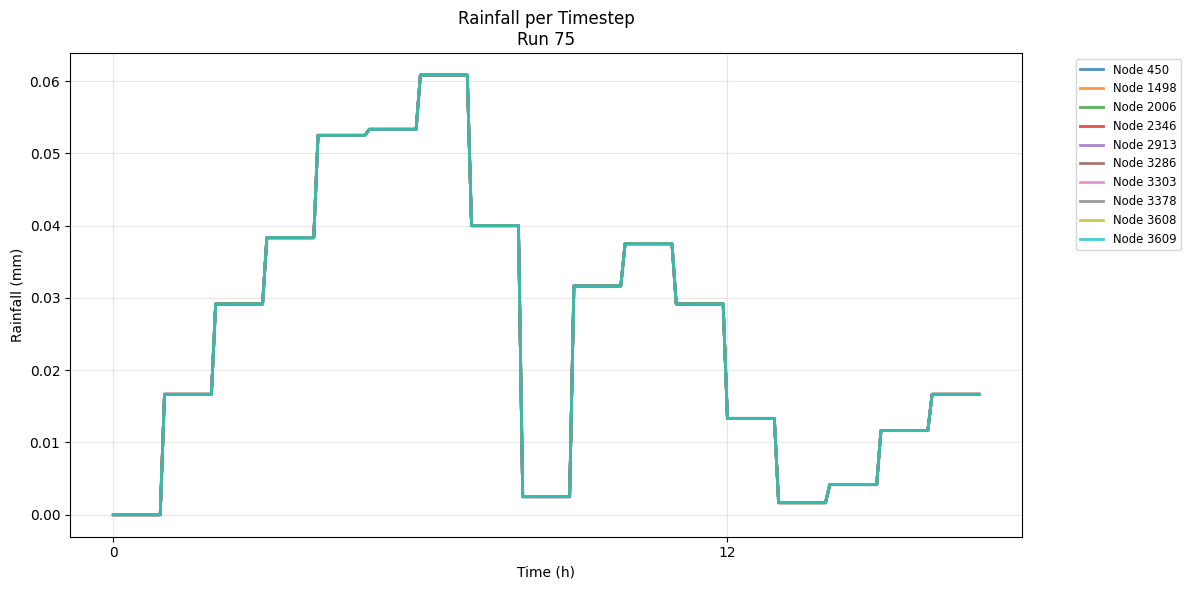

{'run_id': 75,
 'run_index': 5,
 'node_indices': array([ 450, 1498, 2006, 2346, 2913, 3286, 3303, 3378, 3608, 3609]),
 'num_timesteps': 204,
 'num_nodes_plotted': 10}

In [148]:
dynamic_nodes_paths = dataset.processed_paths[4:(num_events + 4)]
node_data_key = 'dynamic_nodes'
rainfall_idx = FloodEvent1D2DDataset.DYNAMIC_NODE_FEATURES.index('rainfall')

# plot_node_timeseries_per_event(
#     dynamic_paths=dynamic_nodes_paths,
#     data_key=node_data_key,
#     feature_name='rainfall',
#     feature_idx=rainfall_idx,
#     ylabel='Rainfall (mm)',
#     title='Rainfall per Timestep',
#     aggregation_func=lambda x: x.sum(axis=1),
# )

# plot_timeseries_per_event(
#     dynamic_paths=dynamic_nodes_paths,
#     data_key=node_data_key,
#     feature_name='rainfall',
#     feature_idx=water_volume_idx,
#     ylabel='Rainfall (mm)',
#     title='Rainfall per Timestep',
#     aggregation_func=lambda x: x.sum(axis=1),
# )

plot_nodes_single_run(
    dynamic_paths=dynamic_nodes_paths,
    data_key=node_data_key,
    feature_name='rainfall',
    feature_idx=rainfall_idx,
    ylabel='Rainfall (mm)',
    title='Rainfall per Timestep',
)

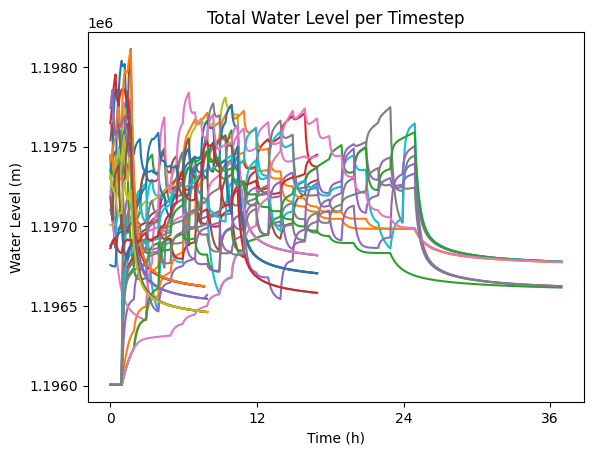

In [149]:
dynamic_nodes_paths = dataset.processed_paths[4:(num_events + 4)]
node_data_key = 'dynamic_nodes'
water_volume_idx = FloodEvent1D2DDataset.DYNAMIC_NODE_FEATURES.index('water_level')

plot_timeseries_per_event(
    dynamic_paths=dynamic_nodes_paths,
    data_key=node_data_key,
    feature_name='water_level',
    feature_idx=water_volume_idx,
    ylabel='Water Level (m)',
    title='Total Water Level per Timestep',
    aggregation_func=lambda x: x.sum(axis=1),
)

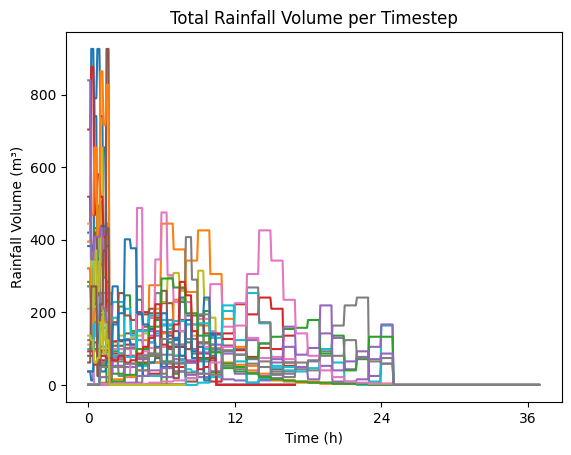

In [150]:
rainfall_idx = FloodEvent1D2DDataset.DYNAMIC_NODE_FEATURES.index('rainfall')

plot_timeseries_per_event(
    dynamic_paths=dynamic_nodes_paths,
    data_key=node_data_key,
    feature_name='rainfall',
    feature_idx=rainfall_idx,
    ylabel='Rainfall Volume (m³)',
    title='Total Rainfall Volume per Timestep',
    aggregation_func=lambda x: x.sum(axis=1),
)

# Plot 1D Dynamic Node Features

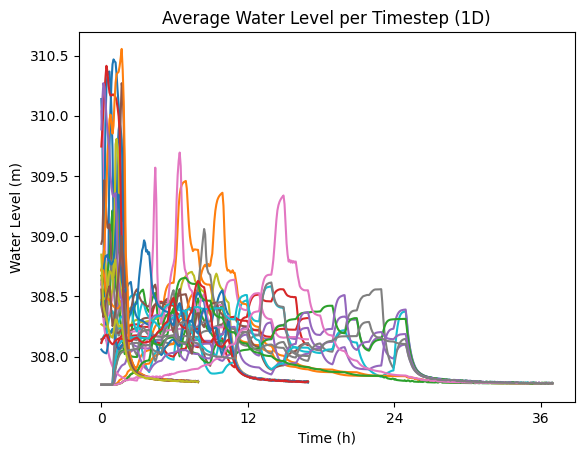

In [151]:
dynamic_nodes_1d_paths = dataset.processed_paths[4:(num_events + 4)]
node_1d_data_key = 'dynamic_nodes_1d'
water_level_idx = FloodEvent1D2DDataset.DYNAMIC_1D_NODE_FEATURES.index('water_level')

plot_timeseries_per_event(
    dynamic_paths=dynamic_nodes_1d_paths,
    data_key=node_1d_data_key,
    feature_name='water_level',
    feature_idx=water_level_idx,
    ylabel='Water Level (m)',
    title='Average Water Level per Timestep (1D)',
    aggregation_func=lambda x: x.mean(axis=1),
)

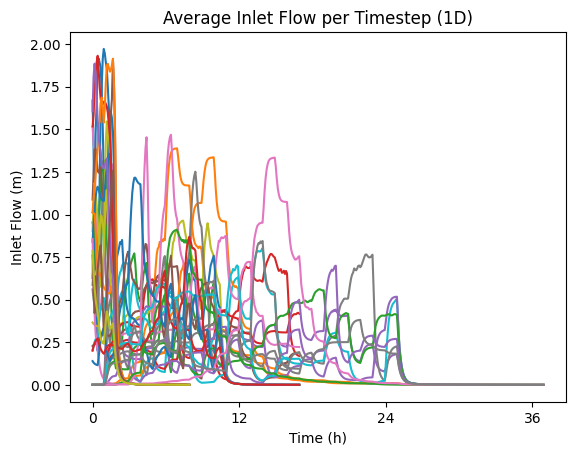

In [152]:
dynamic_nodes_1d_paths = dataset.processed_paths[4:(num_events + 4)]
node_1d_data_key = 'dynamic_nodes_1d'
water_level_idx = FloodEvent1D2DDataset.DYNAMIC_1D_NODE_FEATURES.index('inlet_flow')

plot_timeseries_per_event(
    dynamic_paths=dynamic_nodes_1d_paths,
    data_key=node_1d_data_key,
    feature_name='inlet_flow',
    feature_idx=water_level_idx,
    ylabel='Inlet Flow (m)',
    title='Average Inlet Flow per Timestep (1D)',
    aggregation_func=lambda x: x.mean(axis=1),
)

# Plot 2D Dynamic Edge Features

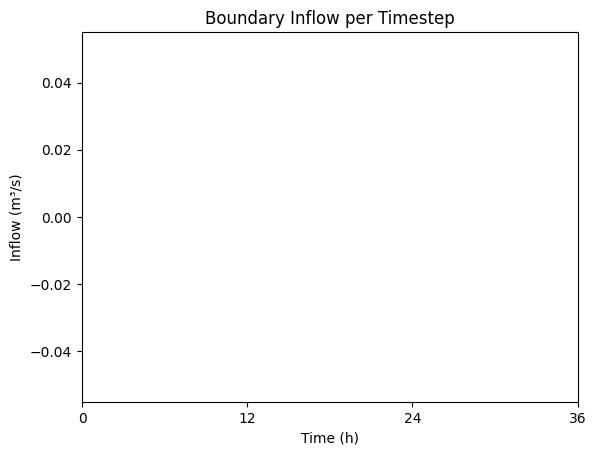

In [153]:
# Plot total inflow per timestep
dynamic_edges_paths = dataset.processed_paths[4:(num_events + 4)]
edge_data_key = 'dynamic_edges'
flow_idx = FloodEvent1D2DDataset.DYNAMIC_EDGE_FEATURES.index('flow')
inflow_edge_mask = dataset.boundary_condition.inflow_edges_mask

plot_timeseries_per_event(
    dynamic_paths=dynamic_edges_paths,
    data_key=edge_data_key,
    feature_name='flow',
    feature_idx=flow_idx,
    ylabel='Inflow (m³/s)',
    title='Boundary Inflow per Timestep',
    mask=inflow_edge_mask,
)

In [154]:
event_end_idx = [*dataset.event_start_idx, dataset.total_rollout_timesteps]
event_size = np.diff(event_end_idx)

for i, run_id in enumerate(dataset.hec_ras_run_ids):
    print(f'Run {run_id} - Event Size: {event_size[i]} timesteps')

Run 26 - Event Size: 92 timesteps
Run 44 - Event Size: 443 timesteps
Run 42 - Event Size: 203 timesteps
Run 73 - Event Size: 203 timesteps
Run 4 - Event Size: 443 timesteps
Run 75 - Event Size: 203 timesteps
Run 54 - Event Size: 92 timesteps
Run 80 - Event Size: 443 timesteps
Run 62 - Event Size: 203 timesteps
Run 8 - Event Size: 443 timesteps
Run 29 - Event Size: 95 timesteps
Run 97 - Event Size: 443 timesteps
Run 53 - Event Size: 95 timesteps
Run 49 - Event Size: 203 timesteps
Run 81 - Event Size: 443 timesteps
Run 61 - Event Size: 92 timesteps
Run 33 - Event Size: 203 timesteps
Run 48 - Event Size: 203 timesteps
Run 37 - Event Size: 95 timesteps
Run 5 - Event Size: 203 timesteps
Run 88 - Event Size: 203 timesteps
Run 83 - Event Size: 95 timesteps
Run 35 - Event Size: 443 timesteps
Run 66 - Event Size: 92 timesteps
Run 76 - Event Size: 443 timesteps
Run 51 - Event Size: 203 timesteps
Run 36 - Event Size: 203 timesteps
Run 96 - Event Size: 203 timesteps
Run 31 - Event Size: 95 timeste

Nodes with the highest water volume difference:
Node 3241: 227.41 m
Node 3240: 216.36 m
Node 3131: 214.38 m
Node 3132: 213.47 m
Node 3133: 150.21 m
Init inflow boundary nodes:  None
Init outflow boundary nodes:  [3741, 3742, 3745, 3748, 3749, 3751, 3756, 3757, 3761, 3762, 3763, 3764]


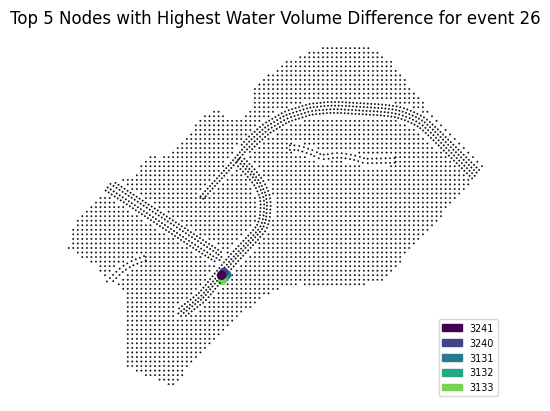

In [155]:
def get_highest_diff_entities(dynamic_path: str,
                              data_key: str,
                              feature_name: str,
                              feature_idx: int,
                              k: int = 4) -> Tuple[List, np.ndarray]:
    data = np.load(dynamic_path)[data_key]
    feature_data = data[:, :, feature_idx]
    feature_data = dataset.normalizer.denormalize(feature_name, feature_data)
    feature_diff = np.abs(np.diff(feature_data, axis=0))
    feature_diff_per_entity = feature_diff.sum(axis=0)

    top_k_diff_idx = np.argsort(feature_diff_per_entity)[-k:][::-1].tolist()
    top_k_wd_diff = feature_diff_per_entity[top_k_diff_idx]
    return top_k_diff_idx, top_k_wd_diff


EVENT_IDX = 0  # Change this to the desired event index
k = 5  # Number of top nodes to retrieve

event_dynamic_nodes_path = dynamic_nodes_paths[EVENT_IDX]
top_k_wv_diff_idx, top_k_wv_diff = get_highest_diff_entities(dynamic_path=event_dynamic_nodes_path,
                                                             data_key=node_data_key,
                                                             feature_name='water_volume',
                                                             feature_idx=water_volume_idx,
                                                             k=k)
print('Nodes with the highest water volume difference:')
for idx, wv in zip(top_k_wv_diff_idx, top_k_wv_diff):
    print(f"Node {idx}: {wv:.2f} m")

run_id = dataset.hec_ras_run_ids[EVENT_IDX]
node_df = plot_utils.get_node_df(config, run_id, mode=mode, no_ghost=True)
plot_utils.plot_cell_map_w_highlight(gpdf=node_df,
                                     title=f'Top {k} Nodes with Highest Water Volume Difference for event {run_id}',
                                     highlight_idxs=top_k_wv_diff_idx)

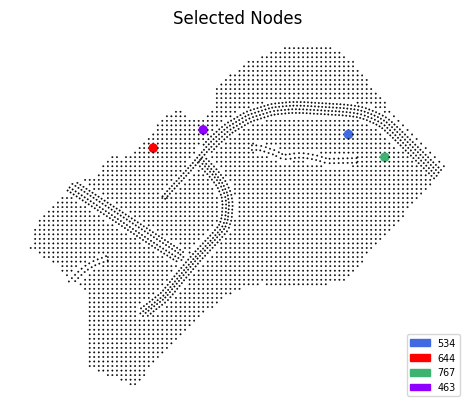

In [156]:
highlight_node_idx = [534, 644, 767, 463]
color_list = ['#4169E1', '#FF0000', '#3CB371', '#8F00FF']
plot_utils.plot_cell_map_w_highlight(node_df,
                                    title='Selected Nodes',
                                    highlight_idxs=highlight_node_idx,
                                    color_list=color_list,
                                    legend=False)

Edges with the highest water flow difference:
Edge 4615: 91.52 m
Edge 3148: 78.99 m
Edge 7438: 75.24 m
Edge 1052: 74.35 m
Edge 4614: 72.14 m
Init inflow boundary nodes:  None
Init outflow boundary nodes:  [3741, 3742, 3745, 3748, 3749, 3751, 3756, 3757, 3761, 3762, 3763, 3764]


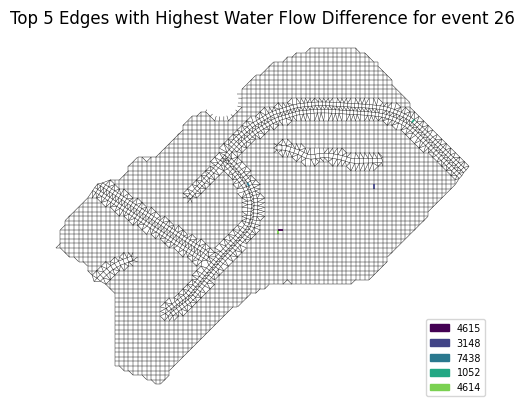

In [157]:
def get_highest_diff_water_flow_edges(dataset: FloodEvent1D2DDataset, event_idx: int, k: int = 4) -> tuple[list, np.ndarray]:
    num_events = len(dataset.hec_ras_run_ids)
    dynamic_edges_paths = dataset.processed_paths[4:(num_events + 4)]

    dynamic_edges = np.load(dynamic_edges_paths[event_idx])['dynamic_edges']
    water_flow_idx = FloodEvent1D2DDataset.DYNAMIC_EDGE_FEATURES.index(FloodEvent1D2DDataset.EDGE_TARGET_FEATURE)
    water_flow = dynamic_edges[:, :, water_flow_idx]
    water_flow = dataset.normalizer.denormalize(FloodEvent1D2DDataset.EDGE_TARGET_FEATURE, water_flow)
    wf_diff = np.abs(np.diff(water_flow, axis=0))
    wf_diff_per_edge = wf_diff.sum(axis=0)

    top_k_diff_idx = np.argsort(wf_diff_per_edge)[-k:][::-1].tolist()
    top_k_wf_diff = wf_diff_per_edge[top_k_diff_idx]
    return top_k_diff_idx, top_k_wf_diff

# def get_edge_df(dataset: FloodEventDataset, no_ghost: bool = True) -> gpd.GeoDataFrame:
#     edges_shp_path = dataset.raw_paths[1]
#     link_df = gpd.read_file(edges_shp_path)

#     if no_ghost:
#         bc = dataset.boundary_condition
#         inflow_boundary_nodes = dataset.inflow_boundary_nodes
#         outflow_boundary_nodes = dataset.outflow_boundary_nodes
#         is_ghost_edge = link_df['from_node'].isin(bc.ghost_nodes) | link_df['to_node'].isin(bc.ghost_nodes)
#         boundary_nodes = np.concat([np.array(dataset.inflow_boundary_nodes), np.array(dataset.outflow_boundary_nodes)])
#         is_boundary_edge = link_df['from_node'].isin(boundary_nodes) | link_df['to_node'].isin(boundary_nodes)
#         link_df = pd.concat([link_df[~is_ghost_edge], link_df[is_ghost_edge & is_boundary_edge]], ignore_index=True)

#         assert np.all(link_df['from_node'][bc.inflow_edges_mask].isin(inflow_boundary_nodes) | link_df['to_node'][bc.inflow_edges_mask].isin(inflow_boundary_nodes)), "Inflow of link DataFrame does not match the inflow edges mask"
#         assert np.all(link_df['from_node'][bc.outflow_edges_mask].isin(outflow_boundary_nodes) | link_df['to_node'][bc.outflow_edges_mask].isin(outflow_boundary_nodes)), "Outflow of link DataFrame does not match the outflow edges mask"

#     return link_df

EVENT_IDX = 0  # Change this to the desired event index
k = 5  # Number of top edges to retrieve

event_dynamic_edges_path = dynamic_edges_paths[EVENT_IDX]
top_k_wf_diff_idx, top_k_wf_diff = get_highest_diff_entities(dynamic_path=event_dynamic_edges_path,
                                                             data_key=edge_data_key,
                                                             feature_name='flow',
                                                             feature_idx=flow_idx,
                                                             k=k)
print('Edges with the highest water flow difference:')
for idx, wf in zip(top_k_wf_diff_idx, top_k_wf_diff):
    print(f"Edge {idx}: {wf:.2f} m")

run_id = dataset.hec_ras_run_ids[EVENT_IDX]
edge_df = plot_utils.get_edge_df(config, run_id, mode=mode, no_ghost=True)
plot_utils.plot_cell_map_w_highlight(gpdf=edge_df,
                                     title=f'Top {k} Edges with Highest Water Flow Difference for event {run_id}',
                                     highlight_idxs=top_k_wf_diff_idx)

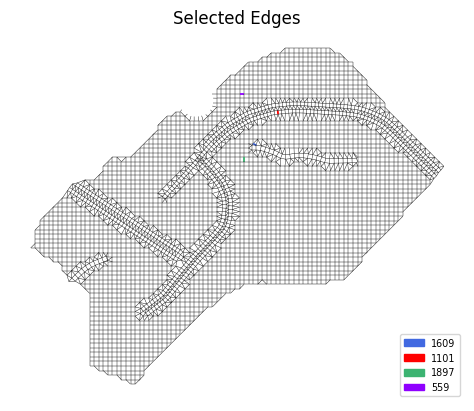

In [158]:
highlight_edge_idx = [1609, 1101, 1897, 559]
color_list = ['#4169E1', '#FF0000', '#3CB371', '#8F00FF']
plot_utils.plot_cell_map_w_highlight(edge_df,
                                     title='Selected Edges',
                                     highlight_idxs=highlight_edge_idx,
                                     color_list=color_list,
                                     legend=True)

In [159]:
feature_stats_path = dataset.processed_paths[1]
feature_stats = file_utils.read_yaml_file(feature_stats_path)
print("Feature statistics:")
for feature_name, stats in feature_stats.items():
    print(f"{feature_name}")
    print(f"\tMean: {stats['mean']:.4f}")
    print(f"\tStd: {stats['std']:.4f}")
    print(f"\tMin: {stats['min']:.4f}")
    print(f"\tMax: {stats['max']:.4f}")

Feature statistics:
area
	Mean: 609.3919
	Std: 116.1106
	Min: -0.0000
	Max: 1218.5624
aspect
	Mean: 184.8906
	Std: 115.0799
	Min: -1.0000
	Max: 359.9294
curvature
	Mean: 0.0001
	Std: 0.0003
	Min: 0.0000
	Max: 0.0052
elevation
	Mean: 323.1608
	Std: 14.4956
	Min: 293.8125
	Max: 360.2188
face_length
	Mean: 25.1484
	Std: 4.2164
	Min: 0.0000
	Max: 51.4703
flow
	Mean: 1.9279
	Std: 4.0940
	Min: -0.1254
	Max: 45.9816
flow_accumulation
	Mean: 1.5137
	Std: 1.4074
	Min: 1.0000
	Max: 31.0000
inlet_flow
	Mean: 0.2206
	Std: 0.6584
	Min: -0.0000
	Max: 9.5051
length
	Mean: 101.9903
	Std: 63.3068
	Min: 12.8575
	Max: 237.4081
position_x
	Mean: 802415.8750
	Std: 134.0707
	Min: 802092.3125
	Max: 802565.3750
position_y
	Mean: 349504.5938
	Std: 297.9814
	Min: 349133.1875
	Max: 350028.9062
rainfall
	Mean: 0.0188
	Std: 0.0290
	Min: 0.0000
	Max: 0.3833
relative_position_x
	Mean: -5.1993
	Std: 17.0455
	Min: -50.0000
	Max: 43.3750
relative_position_y
	Mean: 9.5210
	Std: 15.5559
	Min: -44.9062
	Max: 48.5938
rough

# Plot 2D Static Node & Edge Features

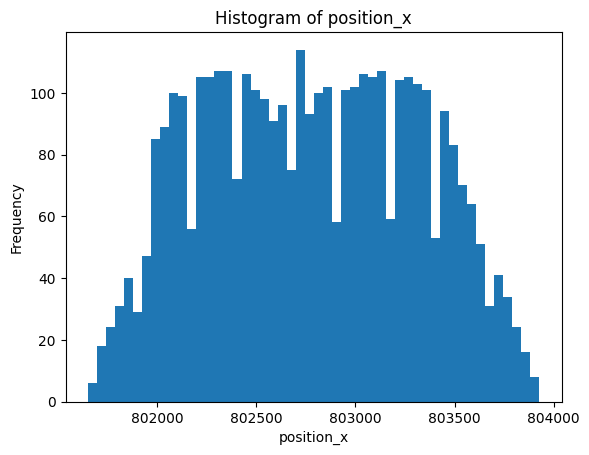

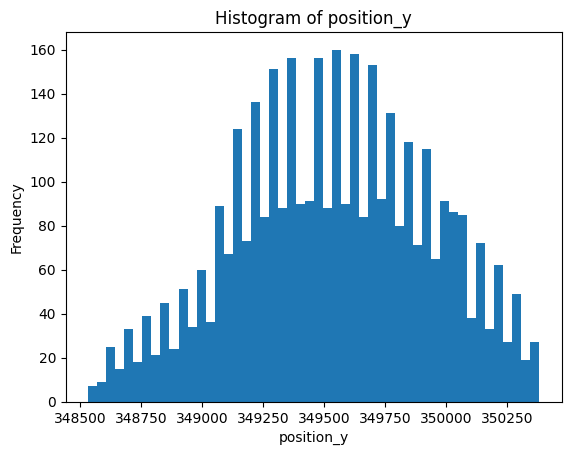

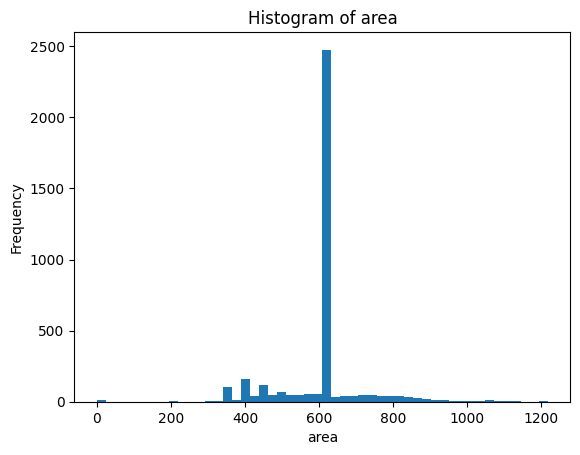

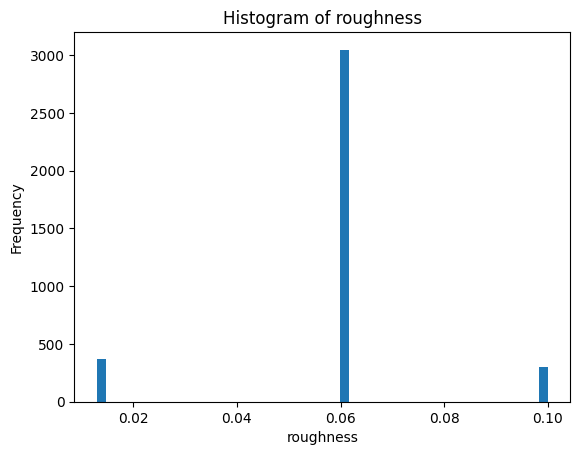

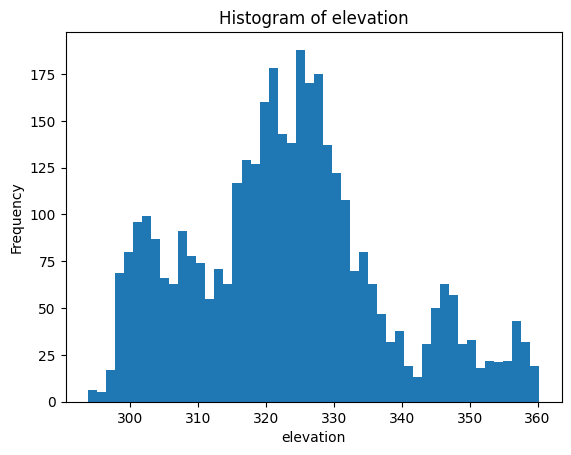

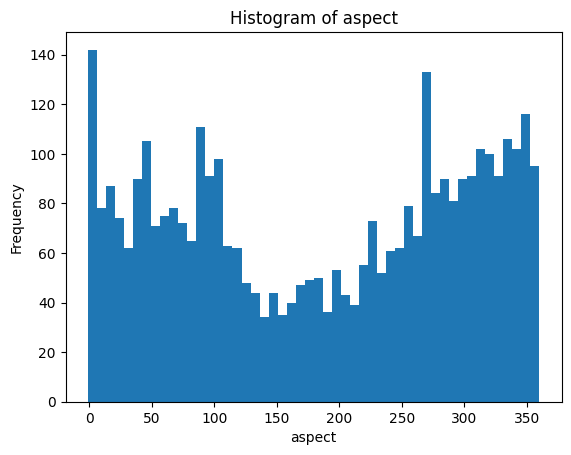

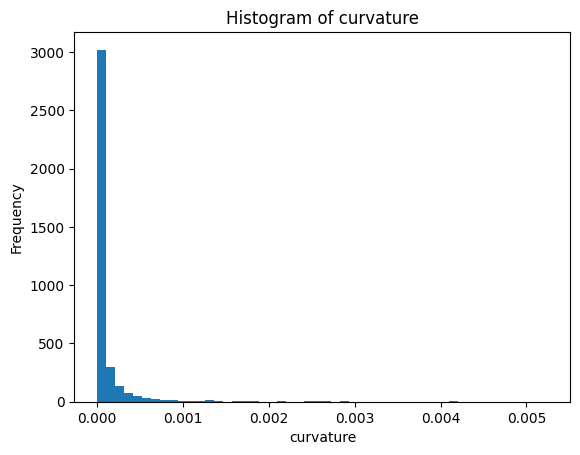

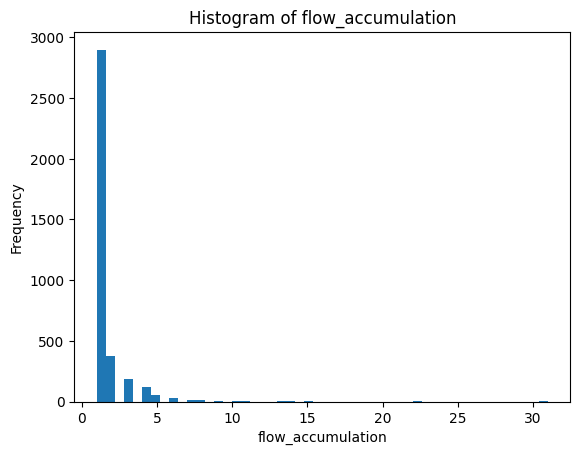

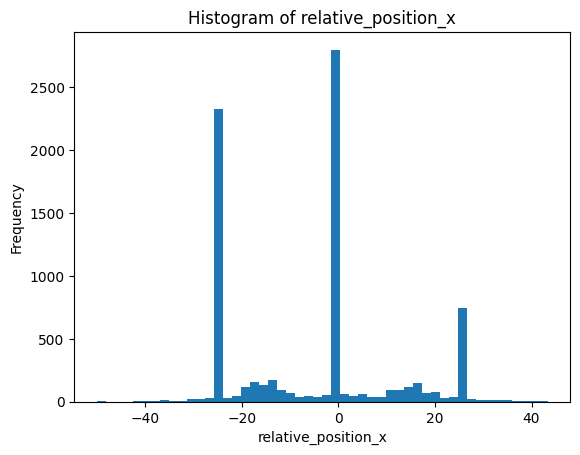

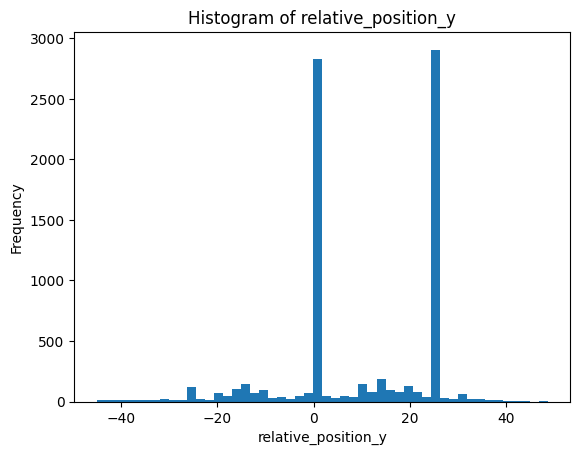

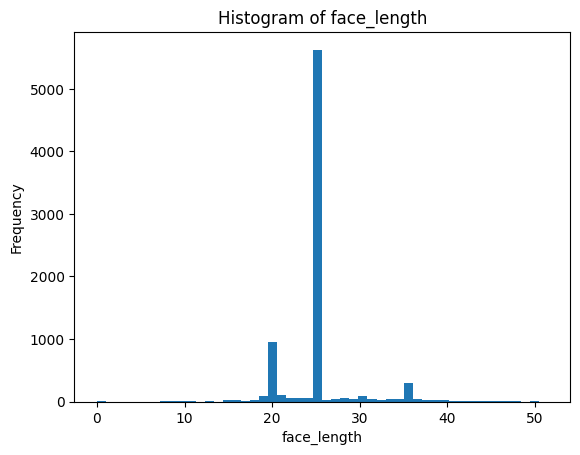

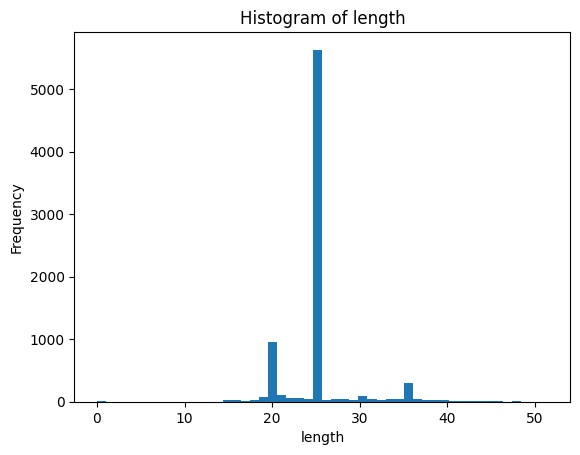

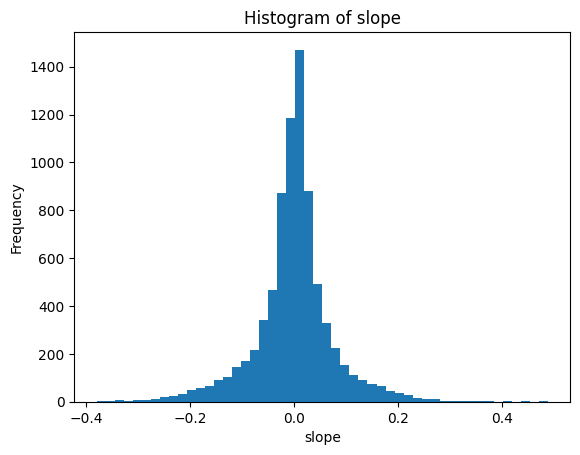

In [160]:
constant_values_path = dataset.processed_paths[3]
bins = 50

static_features = FloodEvent1D2DDataset.STATIC_NODE_FEATURES + FloodEvent1D2DDataset.STATIC_EDGE_FEATURES
feature_idxs = [*(range(dataset.num_static_node_features)), *(range(dataset.num_static_edge_features))]
keys = [*(['static_nodes'] * dataset.num_static_node_features), *(['static_edges'] * dataset.num_static_edge_features)]
for feature, index, key in zip(static_features, feature_idxs, keys):
    data = np.load(constant_values_path)[key]
    feature_data = data[:, index]
    if dataset.is_normalized:
        feature_data = dataset.normalizer.denormalize(feature, feature_data)
    plt.hist(feature_data, bins=bins)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

# Plot 2D Dynamic Node & Edge Features

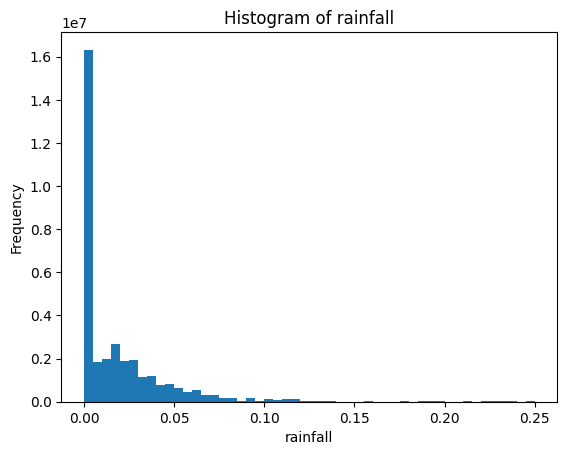

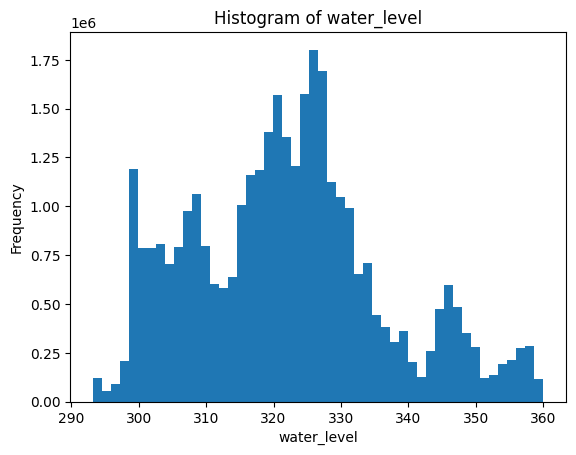

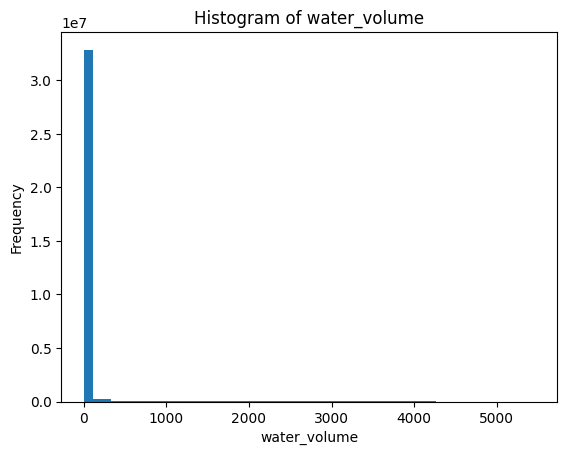

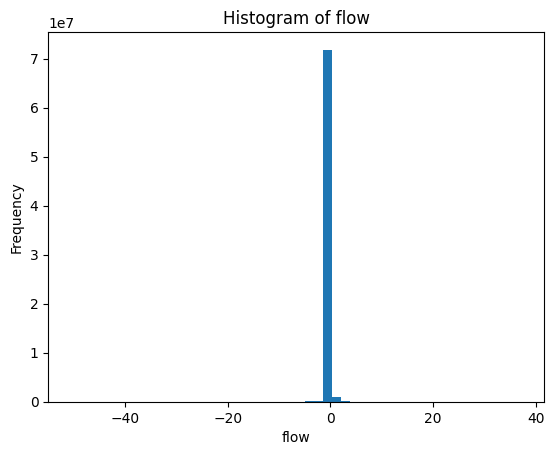

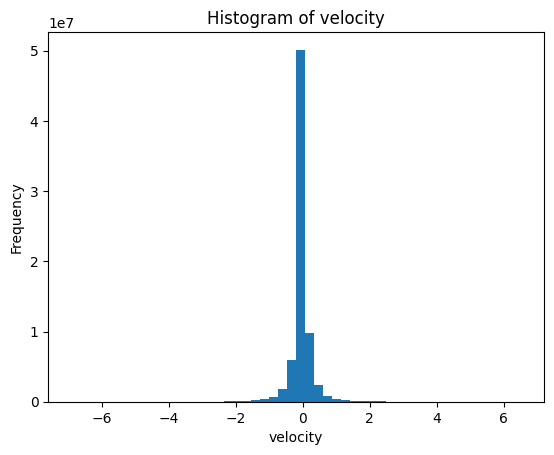

In [161]:
num_events = len(dataset.hec_ras_run_ids)
dynamic_values_paths = dataset.processed_paths[4:(num_events + 4)]

dynamic_features = FloodEvent1D2DDataset.DYNAMIC_NODE_FEATURES + FloodEvent1D2DDataset.DYNAMIC_EDGE_FEATURES
feature_idxs = [*(range(dataset.num_dynamic_node_features)), *(range(dataset.num_dynamic_edge_features))]
keys = [*(['dynamic_nodes'] * dataset.num_dynamic_node_features), *(['dynamic_edges'] * dataset.num_dynamic_edge_features)]
for feature, index, key in zip(dynamic_features, feature_idxs, keys):
    all_feature_data = []
    for path in dynamic_values_paths:
        data = np.load(path)[key]
        feature_data = data[:, :, index]
        if dataset.is_normalized:
            feature_data = dataset.normalizer.denormalize(feature, feature_data)
        all_feature_data.append(feature_data.flatten())
    all_feature_data = np.concatenate(all_feature_data)
    plt.hist(all_feature_data, bins=bins)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


# Plot 1D Static Node & Edge Features

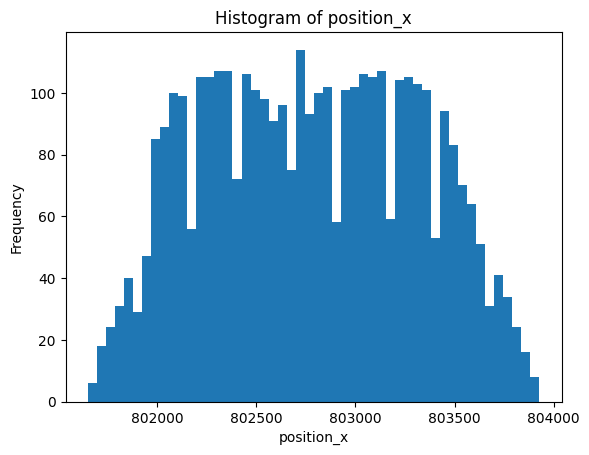

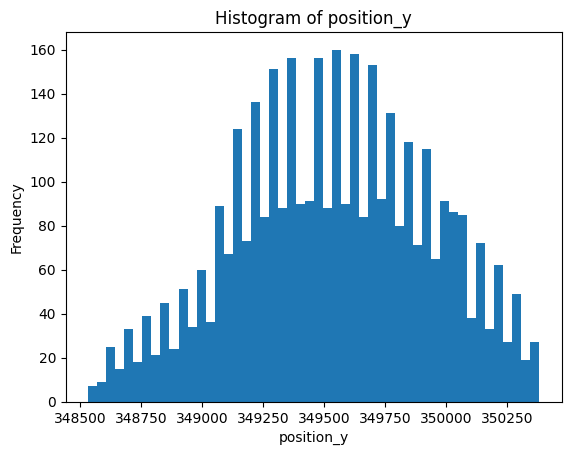

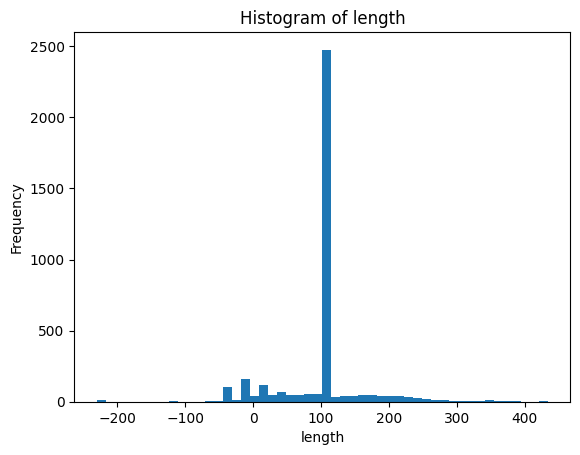

In [162]:
constant_values_path = dataset.processed_paths[3]
bins = 50

static_features = FloodEvent1D2DDataset.STATIC_1D_NODE_FEATURES + FloodEvent1D2DDataset.STATIC_1D_EDGE_FEATURES
feature_idxs = [*(range(dataset.num_static_node_features)), *(range(dataset.num_static_edge_features))]
keys = [*(['static_nodes'] * dataset.num_static_node_features), *(['static_edges'] * dataset.num_static_edge_features)]
for feature, index, key in zip(static_features, feature_idxs, keys):
    data = np.load(constant_values_path)[key]
    feature_data = data[:, index]
    if dataset.is_normalized:
        feature_data = dataset.normalizer.denormalize(feature, feature_data)
    plt.hist(feature_data, bins=bins)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

# Plot 1D Dynamic Node & Edge Features

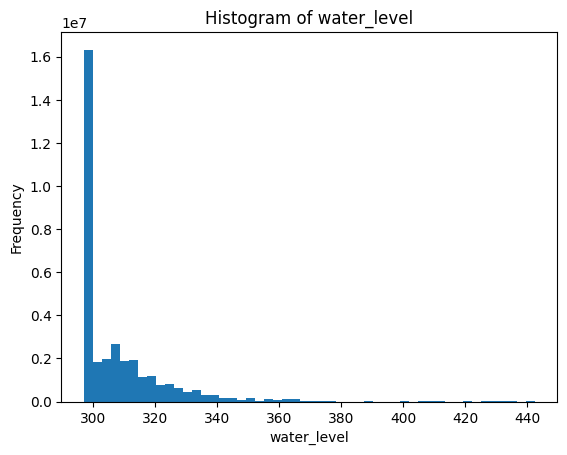

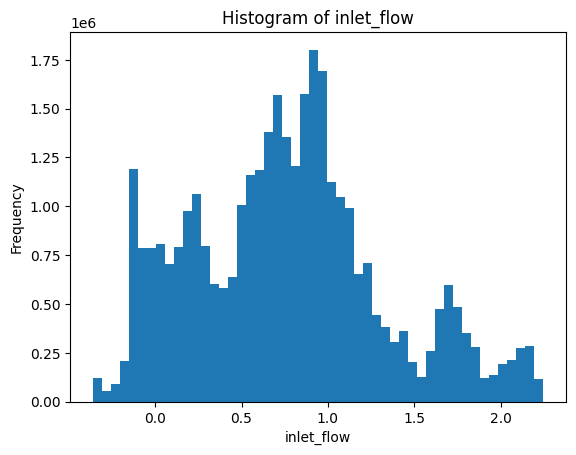

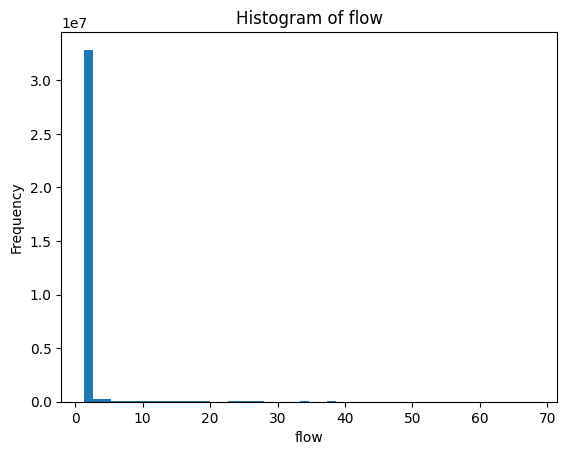

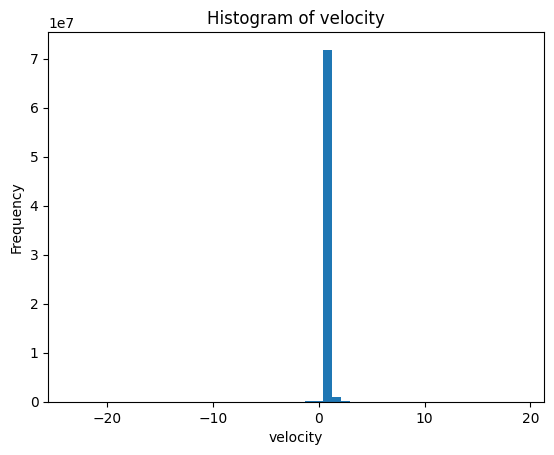

In [163]:
num_events = len(dataset.hec_ras_run_ids)
dynamic_values_paths = dataset.processed_paths[4:(num_events + 4)]

dynamic_features = FloodEvent1D2DDataset.DYNAMIC_1D_NODE_FEATURES + FloodEvent1D2DDataset.DYNAMIC_1D_EDGE_FEATURES
feature_idxs = [*(range(dataset.num_dynamic_node_features)), *(range(dataset.num_dynamic_edge_features))]
keys = [*(['dynamic_nodes'] * dataset.num_dynamic_node_features), *(['dynamic_edges'] * dataset.num_dynamic_edge_features)]
for feature, index, key in zip(dynamic_features, feature_idxs, keys):
    all_feature_data = []
    for path in dynamic_values_paths:
        data = np.load(path)[key]
        feature_data = data[:, :, index]
        if dataset.is_normalized:
            feature_data = dataset.normalizer.denormalize(feature, feature_data)
        all_feature_data.append(feature_data.flatten())
    all_feature_data = np.concatenate(all_feature_data)
    plt.hist(all_feature_data, bins=bins)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


# Plot timeseries graph

### Check the uniformity and pattern of the data

In [164]:
def plot_nodes_from_csv(
    data_csv_path: str,
    timestamp_csv_path: str,
    feature_column: str,
    ylabel: str,
    title: str,
    selected_nodes: Optional[Union[List[int], int]] = None,
    num_random_nodes: int = 10,
    random_seed: Optional[int] = None,
    node_alpha: float = 0.8,
    show_node_ids: bool = True,
    colormap: str = 'tab10',
    timestep_column: str = 'timestep',
    node_column: str = 'node_idx',
    timestamp_idx_column: str = 'timestep_idx',
    timestamp_column: str = 'timestamp',
    date_format: Optional[str] = None,
    time_unit: str = 'auto',  # 'auto', 'hours', 'minutes', 'datetime'
    figsize: tuple = (12, 6),
):
    """
    Plot timeseries for multiple nodes from CSV files.
    
    Reads node data from one CSV and timestamp mapping from another CSV,
    then plots the timeseries of selected nodes.
    
    Args:
        data_csv_path: Path to CSV file containing node data
        timestamp_csv_path: Path to CSV file containing timestep-to-timestamp mapping
        feature_column: Column name of the feature to plot (e.g., 'water_level', 'rainfall')
        ylabel: Label for y-axis
        title: Plot title
        selected_nodes: Specific node indices to plot. Can be:
                       - List of integers: specific node indices
                       - Integer: single node index
                       - None: randomly select nodes
        num_random_nodes: Number of random nodes to select if selected_nodes is None
        random_seed: Seed for random node selection
        node_alpha: Transparency for node lines (0-1)
        show_node_ids: If True, shows node IDs in legend
        colormap: Matplotlib colormap name for node colors
        timestep_column: Column name for timestep in data CSV (default: 'timestep')
        node_column: Column name for node index in data CSV (default: 'node_idx')
        timestamp_idx_column: Column name for timestep index in timestamp CSV (default: 'timestep_idx')
        timestamp_column: Column name for timestamp in timestamp CSV (default: 'timestamp')
        date_format: Format string for parsing timestamps (e.g., '%Y-%m-%d %H:%M:%S')
                    If None, pandas will infer the format
        time_unit: How to display time on x-axis:
                  - 'auto': automatically choose based on data range
                  - 'hours': hours since start
                  - 'minutes': minutes since start
                  - 'datetime': actual datetime values
        figsize: Figure size (width, height)
    
    Returns:
        dict: Contains node_indices, feature statistics, and dataframe
    
    Example:
        >>> # Plot 10 random nodes with water level
        >>> result = plot_nodes_from_csv(
        ...     data_csv_path="simulation_output.csv",
        ...     timestamp_csv_path="timestamps.csv",
        ...     feature_column="water_level",
        ...     ylabel="Water Level (m)",
        ...     title="Water Level at 10 Random Nodes",
        ...     num_random_nodes=10,
        ...     random_seed=42
        ... )
        
        >>> # Plot specific nodes with rainfall
        >>> plot_nodes_from_csv(
        ...     data_csv_path="simulation_output.csv",
        ...     timestamp_csv_path="timestamps.csv",
        ...     feature_column="rainfall",
        ...     ylabel="Rainfall (mm)",
        ...     title="Rainfall at Monitoring Points",
        ...     selected_nodes=[0, 5, 10, 15, 20],
        ...     time_unit='datetime'
        ... )
    """
    
    print("=" * 80)
    print("LOADING DATA FROM CSV FILES")
    print("=" * 80)
    
    # Load data CSV
    print(f"\nLoading data from: {data_csv_path}")
    data_df = pd.read_csv(data_csv_path)
    print(f"  Rows: {len(data_df):,}")
    print(f"  Columns: {list(data_df.columns)}")
    
    # Validate required columns in data CSV
    required_data_cols = [timestep_column, node_column, feature_column]
    missing_cols = [col for col in required_data_cols if col not in data_df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in data CSV: {missing_cols}")
    
    # Load timestamp CSV
    print(f"\nLoading timestamps from: {timestamp_csv_path}")
    timestamp_df = pd.read_csv(timestamp_csv_path)
    print(f"  Rows: {len(timestamp_df):,}")
    print(f"  Columns: {list(timestamp_df.columns)}")
    
    # Validate required columns in timestamp CSV
    required_ts_cols = [timestamp_idx_column, timestamp_column]
    missing_cols = [col for col in required_ts_cols if col not in timestamp_df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in timestamp CSV: {missing_cols}")
    
    # Parse timestamps
    if date_format:
        timestamp_df[timestamp_column] = pd.to_datetime(
            timestamp_df[timestamp_column], 
            format=date_format
        )
    else:
        timestamp_df[timestamp_column] = pd.to_datetime(timestamp_df[timestamp_column])
    
    print(f"  Timestamp range: {timestamp_df[timestamp_column].min()} to {timestamp_df[timestamp_column].max()}")
    
    # Get unique nodes and timesteps
    unique_nodes = sorted(data_df[node_column].unique())
    unique_timesteps = sorted(data_df[timestep_column].unique())
    
    print(f"\nData Summary:")
    print(f"  Unique nodes: {len(unique_nodes)}")
    print(f"  Unique timesteps: {len(unique_timesteps)}")
    print(f"  Feature '{feature_column}' range: [{data_df[feature_column].min():.4f}, {data_df[feature_column].max():.4f}]")
    
    # Set random seed if provided
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # Determine which nodes to plot
    if selected_nodes is None:
        # Randomly select nodes
        node_indices = np.random.choice(
            unique_nodes, 
            size=min(num_random_nodes, len(unique_nodes)), 
            replace=False
        )
        node_indices = np.sort(node_indices)
    elif isinstance(selected_nodes, int):
        # Single node
        node_indices = np.array([selected_nodes])
    else:
        # List of specific nodes
        node_indices = np.array(selected_nodes)
        # Filter out nodes not in data
        valid_mask = np.isin(node_indices, unique_nodes)
        if not np.all(valid_mask):
            invalid_nodes = node_indices[~valid_mask]
            print(f"\nWarning: Removed nodes not in data: {invalid_nodes}")
        node_indices = node_indices[valid_mask]
    
    print(f"\nPlotting {len(node_indices)} nodes: {node_indices}")
    
    # Create time axis based on time_unit setting
    start_time = timestamp_df[timestamp_column].iloc[0]
    
    if time_unit == 'datetime' or time_unit == 'auto':
        # Use actual datetime values
        time_values = timestamp_df[timestamp_column].values
        use_datetime = True
    else:
        # Calculate time differences from start
        time_diffs = (timestamp_df[timestamp_column] - start_time).dt.total_seconds()
        
        if time_unit == 'hours':
            time_values = time_diffs / 3600
            time_label = 'Time (hours)'
        elif time_unit == 'minutes':
            time_values = time_diffs / 60
            time_label = 'Time (minutes)'
        else:
            # Auto-detect best unit
            max_hours = time_diffs.max() / 3600
            if max_hours < 2:
                time_values = time_diffs / 60
                time_label = 'Time (minutes)'
            else:
                time_values = time_diffs / 3600
                time_label = 'Time (hours)'
        
        use_datetime = False
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set up colors
    cmap = plt.cm.get_cmap(colormap)
    colors = cmap(np.linspace(0, 1, len(node_indices)))
    
    # Plot each selected node
    stats = {}
    for idx, node_idx in enumerate(node_indices):
        # Filter data for this node
        node_data = data_df[data_df[node_column] == node_idx].copy()
        
        # Sort by timestep to ensure correct order
        node_data = node_data.sort_values(by=timestep_column)
        
        # Get feature values
        feature_values = node_data[feature_column].values
        timesteps = node_data[timestep_column].values
        
        # Map timesteps to time values
        if use_datetime:
            plot_times = timestamp_df[timestamp_df[timestamp_idx_column].isin(timesteps)][timestamp_column].values
        else:
            plot_times = time_values[timesteps]
        
        # Plot
        if show_node_ids:
            label = f'Node {node_idx}'
        else:
            label = f'Node {idx + 1}'
        
        ax.plot(
            plot_times, 
            feature_values, 
            label=label,
            color=colors[idx],
            alpha=node_alpha,
            linewidth=2,
            marker='o',
            markersize=3,
            markevery=max(1, len(plot_times) // 20)  # Show ~20 markers max
        )
        
        # Store statistics
        stats[f'node_{node_idx}'] = {
            'mean': np.mean(feature_values),
            'std': np.std(feature_values),
            'min': np.min(feature_values),
            'max': np.max(feature_values),
        }
    
    # Configure plot
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    if use_datetime:
        ax.set_xlabel('Time', fontsize=12)
        # Format datetime x-axis
        fig.autofmt_xdate()
    else:
        ax.set_xlabel(time_label, fontsize=12)
    
    ax.set_ylabel(ylabel, fontsize=12)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=1)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 80)
    print("STATISTICS")
    print("=" * 80)
    for node_id, node_stats in stats.items():
        print(f"\n{node_id}:")
        print(f"  Mean: {node_stats['mean']:.4f}")
        print(f"  Std:  {node_stats['std']:.4f}")
        print(f"  Min:  {node_stats['min']:.4f}")
        print(f"  Max:  {node_stats['max']:.4f}")
    
    print("\n" + "=" * 80 + "\n")
    
    # Return information
    return {
        'node_indices': node_indices,
        'num_nodes_plotted': len(node_indices),
        'num_timesteps': len(unique_timesteps),
        'feature_stats': stats,
        'data_df': data_df[data_df[node_column].isin(node_indices)].copy()
    }

LOADING DATA FROM CSV FILES

Loading data from: /Users/jiayulim/Documents/GitHub/dual_flood_gnn/data/Model1/processed/features_csv/train/event_1/2d_nodes_dynamic_all.csv
  Rows: 349,304
  Columns: ['timestep', 'node_idx', 'rainfall', 'water_level', 'water_volume']

Loading timestamps from: /Users/jiayulim/Documents/GitHub/dual_flood_gnn/data/Model1/processed/features_csv/train/event_1/timesteps.csv
  Rows: 94
  Columns: ['timestep_idx', 'timestamp']
  Timestamp range: 2025-10-02 04:00:00 to 2025-10-02 11:45:00

Data Summary:
  Unique nodes: 3716
  Unique timesteps: 94
  Feature 'rainfall' range: [0.0000, 0.1567]

Plotting 20 nodes: [ 181  510  541  565  617  648  654  912 1404 1525 1614 1725 1897 2049
 2323 2877 3053 3293 3318 3567]


/var/folders/fd/qgmtjps95bzf3n9sz761k63h0000gn/T/ipykernel_6920/360294278.py:191: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(colormap)


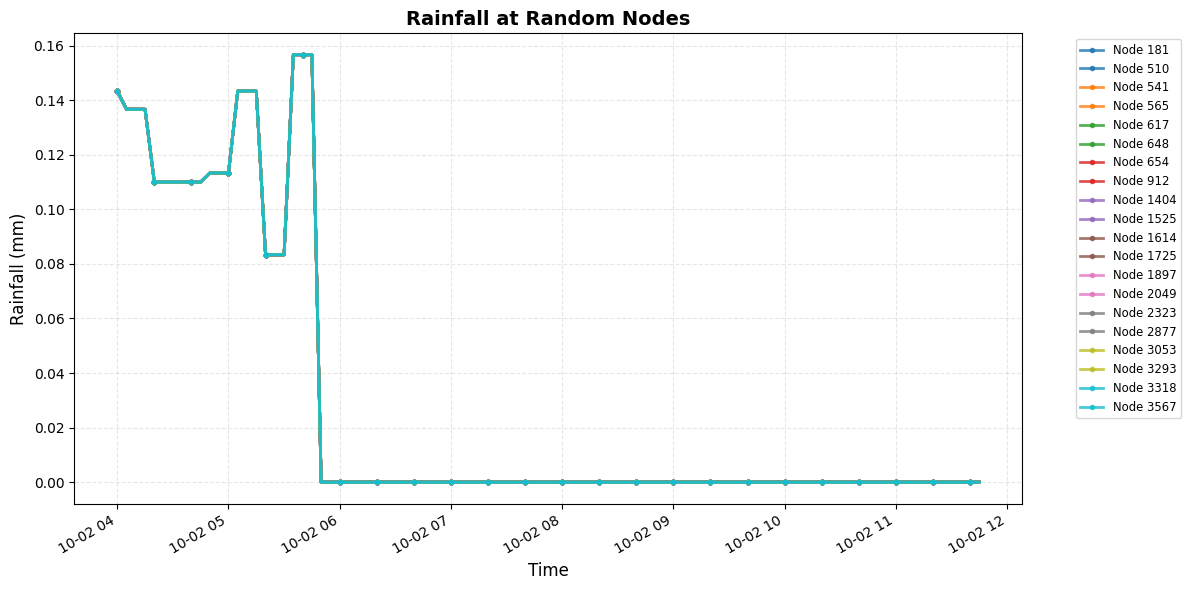


STATISTICS

node_181:
  Mean: 0.0288
  Std:  0.0532
  Min:  0.0000
  Max:  0.1567

node_510:
  Mean: 0.0288
  Std:  0.0532
  Min:  0.0000
  Max:  0.1567

node_541:
  Mean: 0.0288
  Std:  0.0532
  Min:  0.0000
  Max:  0.1567

node_565:
  Mean: 0.0288
  Std:  0.0532
  Min:  0.0000
  Max:  0.1567

node_617:
  Mean: 0.0288
  Std:  0.0532
  Min:  0.0000
  Max:  0.1567

node_648:
  Mean: 0.0288
  Std:  0.0532
  Min:  0.0000
  Max:  0.1567

node_654:
  Mean: 0.0288
  Std:  0.0532
  Min:  0.0000
  Max:  0.1567

node_912:
  Mean: 0.0288
  Std:  0.0532
  Min:  0.0000
  Max:  0.1567

node_1404:
  Mean: 0.0288
  Std:  0.0532
  Min:  0.0000
  Max:  0.1567

node_1525:
  Mean: 0.0288
  Std:  0.0532
  Min:  0.0000
  Max:  0.1567

node_1614:
  Mean: 0.0288
  Std:  0.0532
  Min:  0.0000
  Max:  0.1567

node_1725:
  Mean: 0.0288
  Std:  0.0532
  Min:  0.0000
  Max:  0.1567

node_1897:
  Mean: 0.0288
  Std:  0.0532
  Min:  0.0000
  Max:  0.1567

node_2049:
  Mean: 0.0288
  Std:  0.0532
  Min:  0.0000
  M

{'node_indices': array([ 181,  510,  541,  565,  617,  648,  654,  912, 1404, 1525, 1614,
        1725, 1897, 2049, 2323, 2877, 3053, 3293, 3318, 3567]),
 'num_nodes_plotted': 20,
 'num_timesteps': 94,
 'feature_stats': {'node_181': {'mean': np.float64(0.028758865721682274),
   'std': np.float64(0.05320237935200883),
   'min': np.float64(0.0),
   'max': np.float64(0.1566667556762695)},
  'node_510': {'mean': np.float64(0.028758865721682274),
   'std': np.float64(0.05320237935200883),
   'min': np.float64(0.0),
   'max': np.float64(0.1566667556762695)},
  'node_541': {'mean': np.float64(0.028758865721682274),
   'std': np.float64(0.05320237935200883),
   'min': np.float64(0.0),
   'max': np.float64(0.1566667556762695)},
  'node_565': {'mean': np.float64(0.028758865721682274),
   'std': np.float64(0.05320237935200883),
   'min': np.float64(0.0),
   'max': np.float64(0.1566667556762695)},
  'node_617': {'mean': np.float64(0.028758865721682274),
   'std': np.float64(0.05320237935200883),
 

In [165]:
plot_nodes_from_csv(
    data_csv_path="/Users/jiayulim/Documents/GitHub/dual_flood_gnn/data/Model1/processed/features_csv/train/event_1/2d_nodes_dynamic_all.csv",
    timestamp_csv_path="/Users/jiayulim/Documents/GitHub/dual_flood_gnn/data/Model1/processed/features_csv/train/event_1/timesteps.csv",
    feature_column="rainfall",
    ylabel="Rainfall (mm)",
    title="Rainfall at Random Nodes",
    num_random_nodes=20,
    time_unit='datetime'
)

LOADING DATA FROM CSV FILES

Loading data from: /Users/jiayulim/Documents/GitHub/dual_flood_gnn/data/Model1/processed/features_csv/test/event_8/2d_nodes_dynamic_all.csv
  Rows: 1,653,620
  Columns: ['timestep', 'node_idx', 'rainfall', 'water_level', 'water_volume']

Loading timestamps from: /Users/jiayulim/Documents/GitHub/dual_flood_gnn/data/Model1/processed/features_csv/test/event_8/timesteps.csv
  Rows: 445
  Columns: ['timestep_idx', 'timestamp']
  Timestamp range: 2025-10-02 04:00:00 to 2025-10-03 17:00:00

Data Summary:
  Unique nodes: 3716
  Unique timesteps: 445
  Feature 'rainfall' range: [0.0000, 0.0683]

Plotting 20 nodes: [  41  146  410  796 1122 1316 1390 1620 1634 1756 1771 2074 2078 2090
 2145 2368 2620 2928 3201 3659]


/var/folders/fd/qgmtjps95bzf3n9sz761k63h0000gn/T/ipykernel_6920/360294278.py:191: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(colormap)


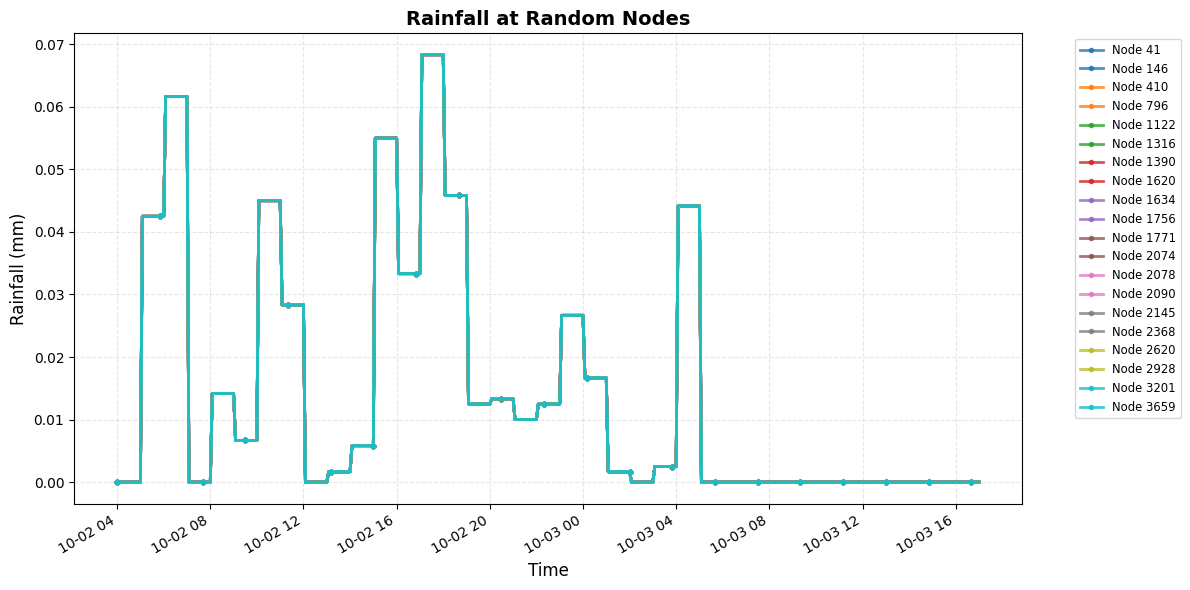


STATISTICS

node_41:
  Mean: 0.0148
  Std:  0.0201
  Min:  0.0000
  Max:  0.0683

node_146:
  Mean: 0.0148
  Std:  0.0201
  Min:  0.0000
  Max:  0.0683

node_410:
  Mean: 0.0148
  Std:  0.0201
  Min:  0.0000
  Max:  0.0683

node_796:
  Mean: 0.0148
  Std:  0.0201
  Min:  0.0000
  Max:  0.0683

node_1122:
  Mean: 0.0148
  Std:  0.0201
  Min:  0.0000
  Max:  0.0683

node_1316:
  Mean: 0.0148
  Std:  0.0201
  Min:  0.0000
  Max:  0.0683

node_1390:
  Mean: 0.0148
  Std:  0.0201
  Min:  0.0000
  Max:  0.0683

node_1620:
  Mean: 0.0148
  Std:  0.0201
  Min:  0.0000
  Max:  0.0683

node_1634:
  Mean: 0.0148
  Std:  0.0201
  Min:  0.0000
  Max:  0.0683

node_1756:
  Mean: 0.0148
  Std:  0.0201
  Min:  0.0000
  Max:  0.0683

node_1771:
  Mean: 0.0148
  Std:  0.0201
  Min:  0.0000
  Max:  0.0683

node_2074:
  Mean: 0.0148
  Std:  0.0201
  Min:  0.0000
  Max:  0.0683

node_2078:
  Mean: 0.0148
  Std:  0.0201
  Min:  0.0000
  Max:  0.0683

node_2090:
  Mean: 0.0148
  Std:  0.0201
  Min:  0.0000


{'node_indices': array([  41,  146,  410,  796, 1122, 1316, 1390, 1620, 1634, 1756, 1771,
        2074, 2078, 2090, 2145, 2368, 2620, 2928, 3201, 3659]),
 'num_nodes_plotted': 20,
 'num_timesteps': 445,
 'feature_stats': {'node_41': {'mean': np.float64(0.014786516682485488),
   'std': np.float64(0.02014951919735904),
   'min': np.float64(0.0),
   'max': np.float64(0.068333625793457)},
  'node_146': {'mean': np.float64(0.014786516682485488),
   'std': np.float64(0.02014951919735904),
   'min': np.float64(0.0),
   'max': np.float64(0.068333625793457)},
  'node_410': {'mean': np.float64(0.014786516682485488),
   'std': np.float64(0.02014951919735904),
   'min': np.float64(0.0),
   'max': np.float64(0.068333625793457)},
  'node_796': {'mean': np.float64(0.014786516682485488),
   'std': np.float64(0.02014951919735904),
   'min': np.float64(0.0),
   'max': np.float64(0.068333625793457)},
  'node_1122': {'mean': np.float64(0.014786516682485488),
   'std': np.float64(0.02014951919735904),
   '

In [166]:
plot_nodes_from_csv(
    data_csv_path="/Users/jiayulim/Documents/GitHub/dual_flood_gnn/data/Model1/processed/features_csv/test/event_8/2d_nodes_dynamic_all.csv",
    timestamp_csv_path="/Users/jiayulim/Documents/GitHub/dual_flood_gnn/data/Model1/processed/features_csv/test/event_8/timesteps.csv",
    feature_column="rainfall",
    ylabel="Rainfall (mm)",
    title="Rainfall at Random Nodes",
    num_random_nodes=20,
    time_unit='datetime'
)